In [1]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(argparse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggsignif))
suppressPackageStartupMessages(library(ggpubr))
options(bitmapType = 'cairo', device = 'png')


setwd('/psycl/g/mpsziller/lucia/SCZ_PGC/eQTL_PROJECT')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
tissues_name <- read.table('Tissues_all', h=F, stringsAsFactors = F)$V1
clust_res <- sprintf('clustering_res_matchUKBB_corrPCs/%s/matchUKBB_tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_minimal.RData', tissues_name)

outFold <- sprintf('%sSCZ_clustering/', fold_notebook)
type_data <- 'tscore'
type_input <- 'zscaled'
type_cluster <- 'Cases'
pheno_name <- 'SCZ'
color_tissues_file <- sprintf('%scolor_tissues.txt', fold_notebook)                      
color_tissues <- read.table(color_tissues_file, h=T, stringsAsFactors = F)

In [19]:

compute_NMI <- function(tissues_name, clust_res){
    NMI_mat <- matrix(0, ncol = length(tissues_name), nrow = length(tissues_name))
    df_cluster <- data.frame(tissue = tissues_name, n_cluster = NA)
    df_div <- data.frame(tissue = c(), n_samples = c(), gr = c() )

    for(i in 1:length(tissues_name)){
      # print(i)
        tmp <- get(load(clust_res[i]))
        cl1 <- tmp$cl_best$gr
        df_cluster$n_cluster[i] <- length(unique(tmp$cl_best$gr))
        df_div <- rbind(df_div, data.frame(tissue = rep(tissues_name[i], length(unique(tmp$cl_best$gr))), 
                                           n_samples = sapply(sort(unique(cl1)), function(x) sum(cl1 == x)), gr = sort(unique(cl1))))
  
      if(i<length(tissues_name)){
        for(j in (i+1):length(tissues_name)){
      
            tmp <- get(load(clust_res[j]))
            cl2 <- tmp$cl_best$gr
            NMI_mat[i, j] <- compare(cl1, cl2, method = 'nmi')
        }
      }
    }
    rownames(NMI_mat) <- colnames(NMI_mat) <- tissues_name
    NMI_mat <- NMI_mat + t(NMI_mat)
    diag(NMI_mat) <- NA
    return(list(NMI_mat, df_div))  
}
                                                              
                                                              
tot <- compute_NMI(tissues_name, clust_res)
NMI_mat <- tot[[1]] 
df_out <- tot[[2]]                                                              


png 
  2

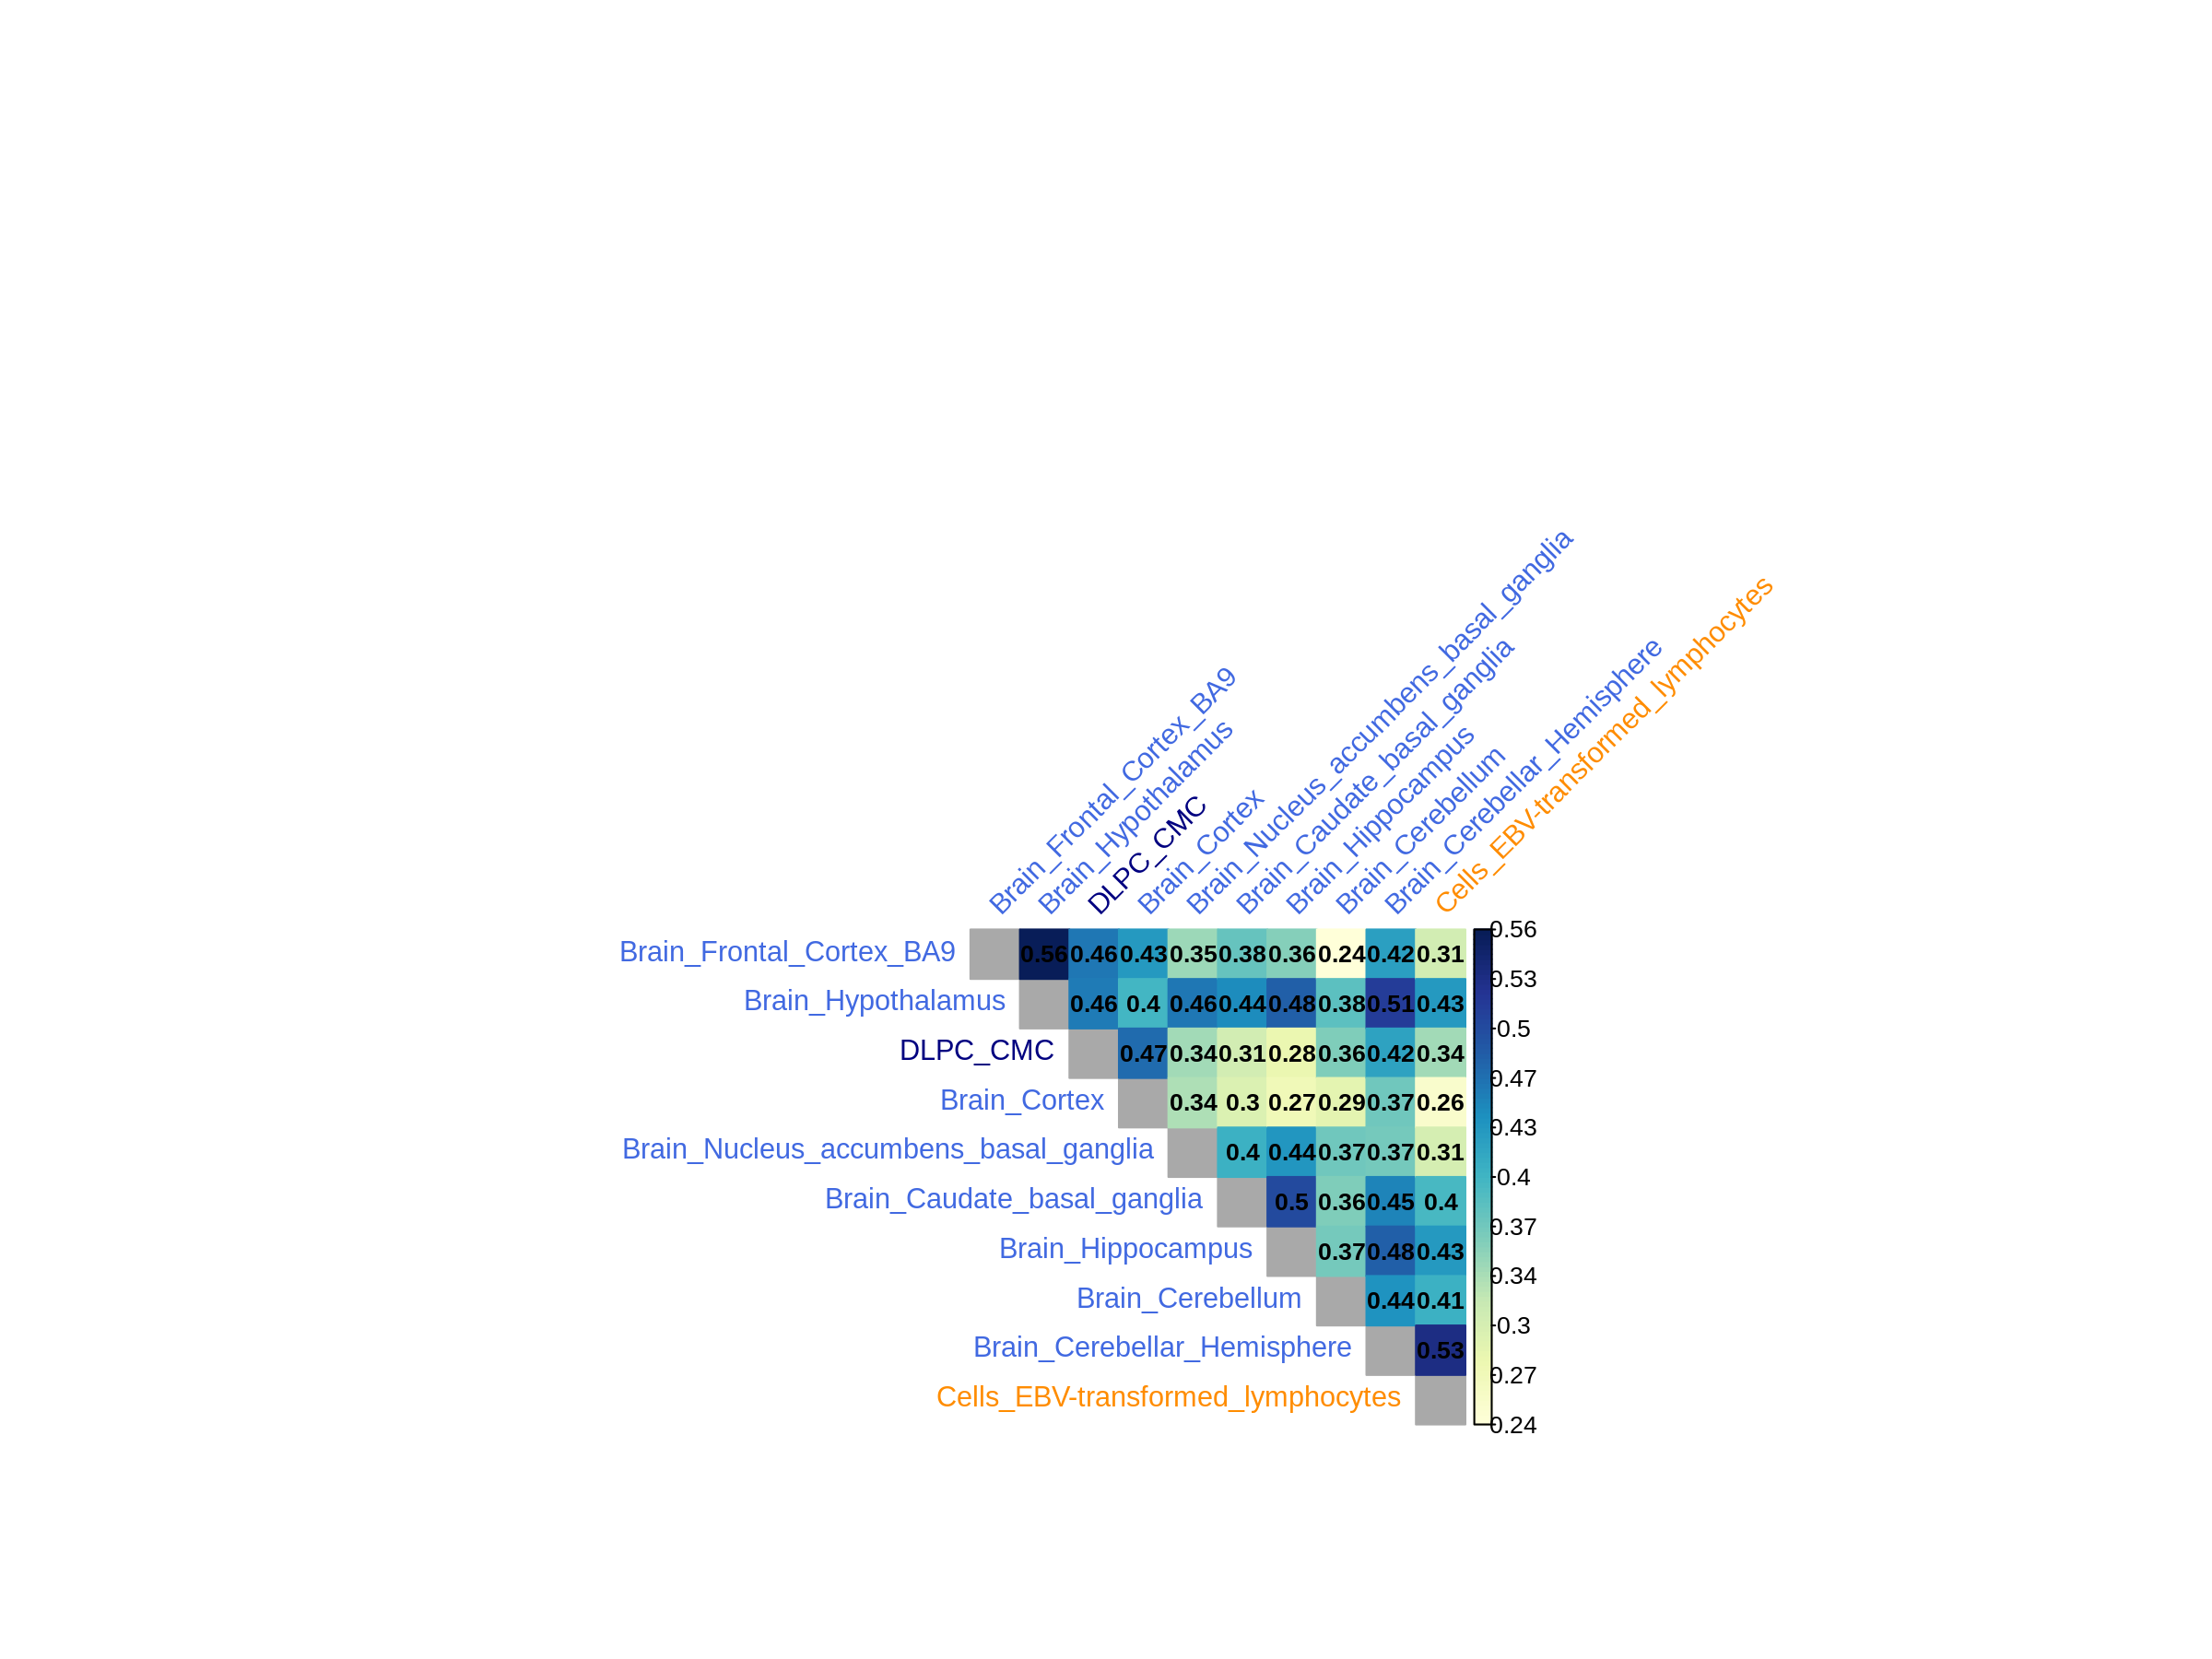

In [30]:
### plot NMI ###
options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 200)

col <- colorRampPalette(brewer.pal(9, 'YlGnBu'))(100)
ord <- corrMatOrder(NMI_mat, order="hclust", hclust.method = 'ward.D')
newcolours <- color_tissues$color[match(tissues_name, color_tissues$tissues)][ord]
title_pl <- sprintf('NMI %s %s', type_data, type_input)
  
pdf(file = sprintf('%sNMI_%s_%s.pdf', outFold, type_data, type_input), width = 10, height = 7, compress = F, pointsize = 12)
corrplot(NMI_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',
         tl.col = newcolours, tl.cex=0.92,
         col = c(col), method = 'color', tl.srt=45, cl.align.text='c',
         addCoef.col = "black",na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.8, mar = c(0,0,1,0))
dev.off()


corrplot(NMI_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',
         tl.col = newcolours, tl.cex=0.92,
         col = c(col), method = 'color', tl.srt=45, cl.align.text='c',
         addCoef.col = "black",na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.8, mar = c(0,0,1,0))


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


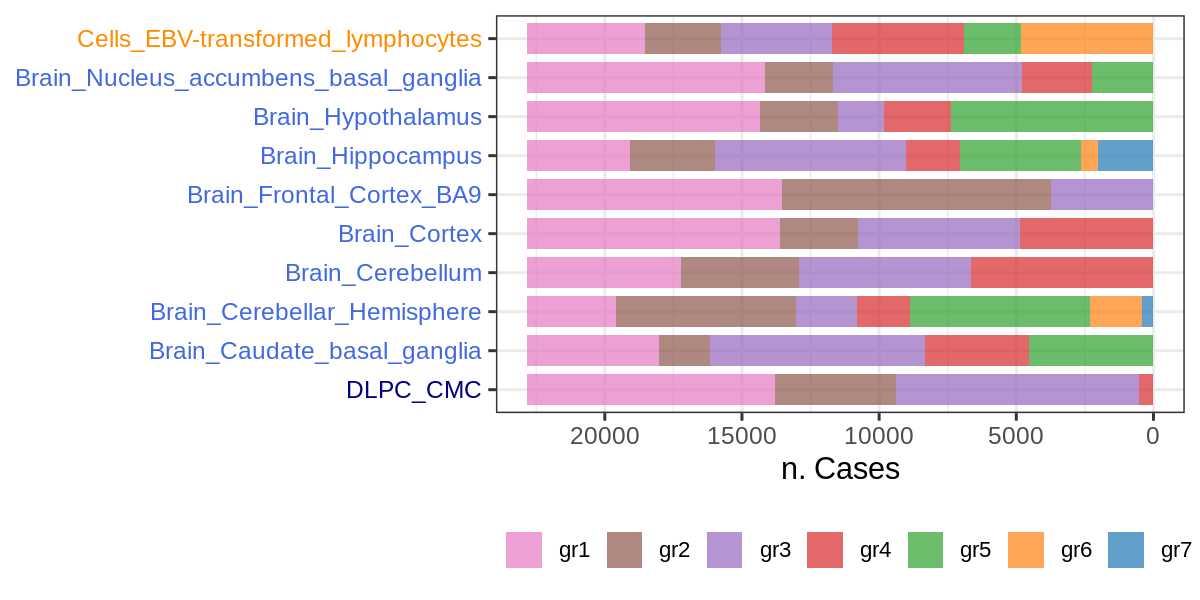

In [22]:
# plot number group per tissue
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)

df_tot <- df_out
df_tot $gr <- paste0('gr', df_tot $gr)
max_gr <- max(as.numeric(sapply(unique(as.character(df_tot$gr)), function(x) strsplit(x, 'gr')[[1]][2])))
df_tot$gr <- factor(df_tot$gr, levels = paste0('gr', 1:max_gr))

df_tot$tissue <- factor(df_tot$tissue, levels = tissues_name)
newcolours <- color_tissues$color[match(tissues_name, color_tissues$tissues)]
color_gr <- rev(pal_d3("category20")(length(levels(df_tot$gr))))

pl <- ggplot(data = df_tot, aes(x = tissue, y = n_samples, fill = gr))+
    geom_bar(alpha = 0.7, width = 0.8, stat = 'identity')+
    ylab('n. Cases')+ 
    theme_bw()+ 
    theme(legend.position = 'bottom', 
          legend.text = element_text(size = 8), legend.title = element_blank(), 
          legend.key.size = unit(0.5, "cm"),
          axis.title.y = element_blank(), axis.text.y = element_text(colour = newcolours))+
    scale_fill_manual(values = color_gr) +
    coord_flip() + 
    scale_y_reverse() +
    guides(fill = guide_legend(nrow = 1))
  
ggsave(filename = sprintf('%scluster_nsamples_%s_%s.pdf', outFold, type_data, type_input), plot = pl, width = 6, height = 3, dpi = 200, compress = F)
pl

In [24]:
df_tot[order(df_tot$n_samples),]

,tissue,n_samples,gr
,<fct>,<int>,<fct>
16,Brain_Cerebellar_Hemisphere,421,gr7
4,DLPC_CMC,520,gr4
33,Brain_Hippocampus,610,gr6
37,Brain_Hypothalamus,1655,gr3
6,Brain_Caudate_basal_ganglia,1854,gr2
15,Brain_Cerebellar_Hemisphere,1904,gr6
13,Brain_Cerebellar_Hemisphere,1934,gr4
31,Brain_Hippocampus,1959,gr4
34,Brain_Hippocampus,2028,gr7
